# Tutorial
## Getting started
### Import library and packages

In [1]:
import os
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import ResoFit
from ResoFit.calibration import Calibration
from ResoFit.fitresonance import FitResonance
from ResoFit.experiment import Experiment
from ResoFit._utilities import Layer
import numpy as np
import matplotlib.pyplot as plt

### Global paramters
  - min energy of **7 eV** (has to be greater than **1 x 10<sup>-5</sup> eV**)
  - max energy of **150 eV** (has to be less than **3000 eV**)
  - energy steps to interpolate database: **0.1 eV**

In [2]:
energy_min = 7
energy_max = 150
energy_step = 0.01

### File locations 

  - data/* (directory to locate the file)
  - data_file (YOUR_DATA_FILE.txt or .csv)
  - spectra_file (YOUR_SPECTRA_FILE.txt or .csv)

In [3]:
folder = 'data/_data_for_tutorial'
data_file = 'raw_data.csv'
spectra_file = 'spectra.txt'

## Preview data using Experiment()

**Note** this is meant to demenstrate the functionality of Experiment() class. These operations are not needed for general calibration and fitting.

### Load the related files into Experiment()

In [4]:
experiment = Experiment(data_file=data_file,
                        spectra_file=spectra_file,
                        folder=folder)

### Data

- Values are in transmission with image number as indexes after extracting with ImageJ

In [5]:
experiment.data

,0
0,1.025803
1,1.027222
2,1.029864
3,1.029095
4,1.032496
5,1.038683
6,1.042255
7,1.041075
8,1.034811
9,1.031851


### Spectra

- **Column 0** time values (seconds) with image number as indexes

- **Column 1** neutron counts

In [6]:
experiment.spectra

,0,1
0,9.600000e-07,22192427
1,1.120000e-06,20966591
2,1.280000e-06,19678909
3,1.440000e-06,19890967
4,1.600000e-06,20968632
5,1.760000e-06,21026731
6,1.920000e-06,20464927
7,2.080000e-06,21112328
8,2.240000e-06,22520473
9,2.400000e-06,22849349


## Remove unwanted data points

In [7]:
experiment.slice(slice_start=3, slice_end=2801, reset_index=False)

(3       0.000001
 4       0.000002
 5       0.000002
 6       0.000002
 7       0.000002
 8       0.000002
 9       0.000002
 10      0.000003
 11      0.000003
 12      0.000003
 13      0.000003
 14      0.000003
 15      0.000003
 16      0.000004
 17      0.000004
 18      0.000004
 19      0.000004
 20      0.000004
 21      0.000004
 22      0.000004
 23      0.000005
 24      0.000005
 25      0.000005
 26      0.000005
 27      0.000005
 28      0.000005
 29      0.000006
 30      0.000006
 31      0.000006
 32      0.000006
           ...   
 2771    0.000444
 2772    0.000444
 2773    0.000445
 2774    0.000445
 2775    0.000445
 2776    0.000445
 2777    0.000445
 2778    0.000445
 2779    0.000446
 2780    0.000446
 2781    0.000446
 2782    0.000446
 2783    0.000446
 2784    0.000446
 2785    0.000447
 2786    0.000447
 2787    0.000447
 2788    0.000447
 2789    0.000447
 2790    0.000447
 2791    0.000448
 2792    0.000448
 2793    0.000448
 2794    0.000448
 2795    0

### Retrieve values for *X-axis*
#### In 'neutron energy'

In [8]:
experiment.x_raw(offset_us=0., source_to_detector_m=16)

array([  6.45188613e+05,   5.22602776e+05,   4.31903121e+05, ...,
         6.64684718e+00,   6.64210874e+00,   6.63737536e+00])

#### In 'neutron wavelength'

In [9]:
experiment.x_raw(angstrom=True, offset_us=0., source_to_detector_m=16)

array([ 0.00035604,  0.0003956 ,  0.00043516, ...,  0.11092624,
        0.1109658 ,  0.11100536])

### Retrieve values for *Y-axis*
#### In 'neutron attenuation'

In [10]:
experiment.y_raw()

array([-0.029095, -0.032496, -0.038683, ...,  0.071846,  0.081125,
        0.080068])

#### In 'neutron transmission'

In [11]:
experiment.y_raw(transmission=True)

array([ 1.029095,  1.032496,  1.038683, ...,  0.928154,  0.918875,
        0.919932])

#### In 'neutron attenuation' & remove baseline

In [12]:
experiment.y_raw(baseline=True)

array([ 0.0183733 ,  0.01488139,  0.00860353, ...,  0.01160011,
        0.02088986,  0.01984365])

### Retrieve interpolated values for both *X-axis* & *Y-axis*

**X-axis**: 'neutron energy'

**Y-axis**: 'neutron attenuation'

In [13]:
experiment.xy_scaled(energy_min=energy_min, energy_max=energy_max, energy_step=energy_step,
                     angstrom=False, transmission=False,
                     offset_us=0, source_to_detector_m=15, 
                     baseline=True)

(array([   7.  ,    7.01,    7.02, ...,  149.98,  149.99,  150.  ]),
 array([ 0.00584673, -0.00275185,  0.00486153, ...,  0.01071007,
         0.01063659,  0.01056193]))

### Plot raw in various ways 

#### Attenuation vs. image number

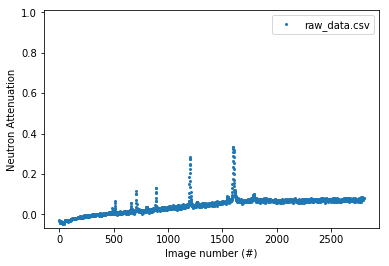

In [14]:
experiment.plot_raw(x_axis='number')
plt.show()

#### Attenuation vs. recorded time

**Parameters need to be specified:**
- `time_unit` from `['s', 'us', 'ns']`. **('us')** is default


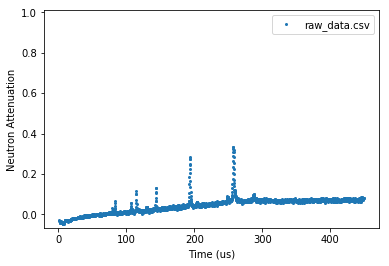

In [15]:
experiment.plot_raw(x_axis='time')
plt.show()

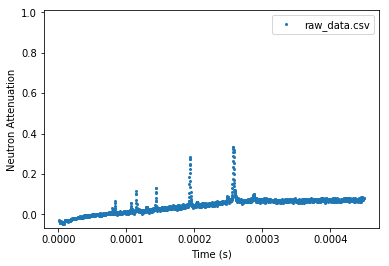

In [16]:
experiment.plot_raw(x_axis='time', time_unit='s')
plt.show()

#### Attenuation vs. neutron wavelength

**Parameters need to be specified:**
- `lambda_xmax` in **(angstrom)**
- `offset_us` in **(us)**
- `source_to_detector_m` in **(m)**

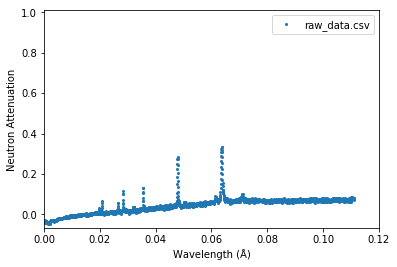

In [17]:
experiment.plot_raw(x_axis='lambda', lambda_xmax=0.12,
                   offset_us=0, source_to_detector_m=16)
plt.show()

#### Attenuation vs. neutron energy

**Parameters need to be specified:**
- `energy_xmax` in **(eV)**
- `offset_us` in **(us)**
- `source_to_detector_m` in **(m)**

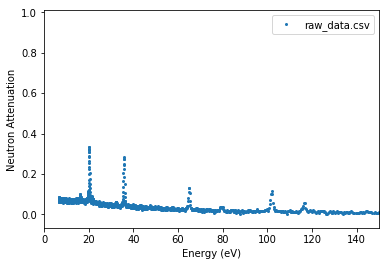

In [18]:
experiment.plot_raw(x_axis='energy', energy_xmax=150,
                    offset_us=0, source_to_detector_m=16)
plt.show()

#### Remove baseline for plot

**Note:** this only changes the display of data, not the data values.


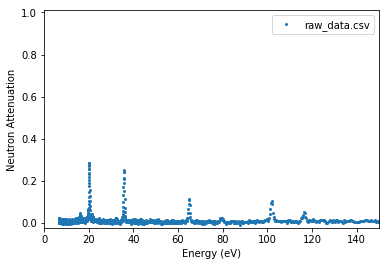

In [19]:
experiment.plot_raw(offset_us=0, source_to_detector_m=16,
                    x_axis='energy', baseline=True, 
                    energy_xmax=150)
plt.show()

#### Operation to experiment data

`experiment.norm_to(file=background.csv)`

This can be used to further normalize signal. (data divide background)

**Note:** this will change the data values.

## Input sample info

  - **Gd** and **U** mixed foil
  - **thickness** neutron path within the sample in (**mm**)
  - **density** sample density in (**g/cm<sup>3</sup>**), if omitted, pure solid density will be used in fitting
  - **repeat** : reptition number if the data is summed of multiple runs (**default: 1**)

In [20]:
layer_1 = 'U'
thickness_1 = 0.05 # mm
density_1 = None # g/cm^3 (if None or omitted, pure solid density will be used in fitting step)
layer_2 = 'Gd'
thickness_2 = 0.05 # mm
density_2 = None # g/cm^3 (if None or omitted, pure solid density will be used in fitting step)

- Create sample layer

**Note**: Input each element as single layer.

In [21]:
layer = Layer()
layer.add_layer(layer=layer_1, thickness_mm=thickness_1, density_gcm3=density_1)
layer.add_layer(layer=layer_2, thickness_mm=thickness_2, density_gcm3=density_2)

## Calibration
### Estimated intrumental parameters

  - input estimated **source to detector distance** (**m**)
  - input estimated possible **time offset** in spectra file (**us**)
  
**Note**: a separated Experiment() will be created after the initialization of Calibration(). Calibration.slice() is needed if you would like to remove unwanted data points by indexes.

In [22]:
source_to_detector_m = 16.
offset_us = 0

### Class initialization

  - Pass all the parameters definded above into the Calibration()

In [23]:
calibration = Calibration(data_file=data_file,
                          spectra_file=spectra_file,
                          raw_layer=layer,
                          energy_min=energy_min,
                          energy_max=energy_max,
                          energy_step=energy_step,
                          folder=folder,
                          baseline=True)

### Equations for (time-wavelength-energy) conversion



$$E = \frac {81.787 }{ \lambda^2 }$$

$E$ : energy in (meV),

$\lambda$ : wavelength in (Å).

$$\lambda  = 0.3956\frac{t_{record} + t_{offset}}{L}$$

$t_{record}$ : recorded time in (µs),

$t_{offset}$ : recorded time offset in (µs),

$L$ : source to detector distance in (cm).

### Calibrate instrumental parameters

  - using **source_to_detector_m** or **offset_us** or **both** to minimize the difference between the measured resonance signals and the simulated resonance signals from *ImagingReso* within the range specified in **global parameters**
  - **vary** can be one of **['source_to_detector', 'offset', 'all']** (default is **'all'**)
  - fitting parameters are displayed

In [24]:
calibration.calibrate(source_to_detector_m=source_to_detector_m,
                      offset_us=offset_us,
                      vary='all')

-------Calibration-------
Params before:
Name                     Value      Min      Max   Stderr     Vary     Expr Brute_Step
offset_us                    0     -inf      inf     None     True     None     None
source_to_detector_m        16     -inf      inf     None     True     None     None
Params after:
Name                     Value      Min      Max   Stderr     Vary     Expr Brute_Step
offset_us                2.755     -inf      inf  0.03047     True     None     None
source_to_detector_m     16.44     -inf      inf 0.002896     True     None     None
Calibration chi^2 : 51.508119690122165



### Retrieve calibrated parameters

In [25]:
calibration.calibrated_offset_us

2.754524867719895

In [26]:
calibration.calibrated_source_to_detector_m

16.437347811454231

### Plot calibration result

  - using the best fitted **source_to_detector_m** and **offset_us** to show the calibrated resonance signals from measured data and the expected resonance positions from *ImagingReso*
  - measured data before and after is ploted with raw data points instead of interpolated data points. However, the interpolated data was used during the calibration step above.

#### Default layout

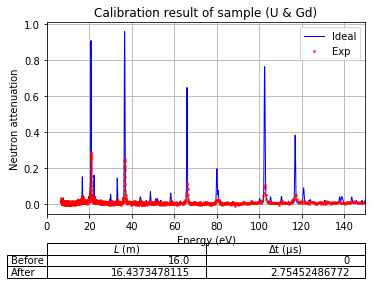

In [27]:
calibration.plot()

#### Hide table

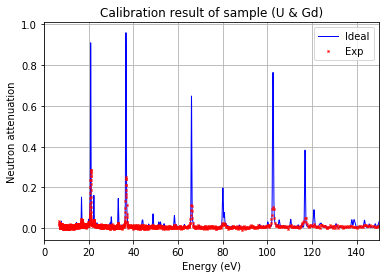

In [28]:
calibration.plot(table=False)

#### Hide grid

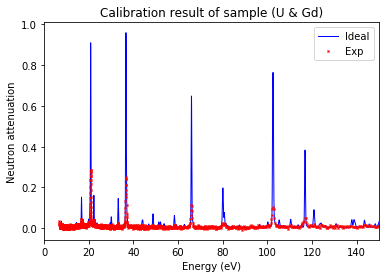

In [29]:
calibration.plot(table=False, grid=False)

#### Plot before to compare

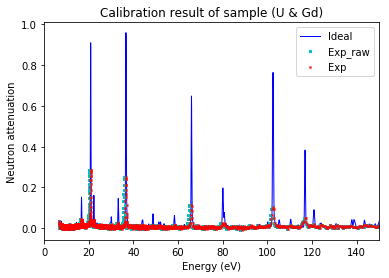

In [30]:
calibration.plot(table=False, grid=False, before=True)

#### Show all elements

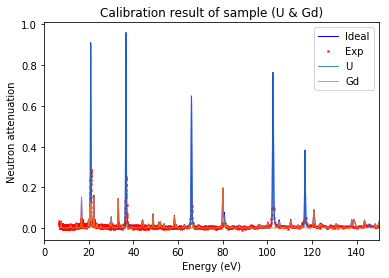

In [31]:
calibration.plot(table=False, grid=False, all_elements=True)

#### Show all isotopes

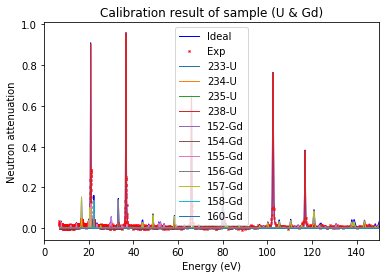

In [32]:
calibration.plot(table=False, grid=False, all_isotopes=True)

#### Show specified items

- Format as **list** with each name in **string**

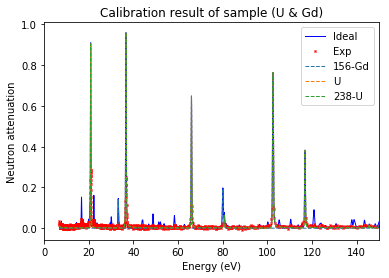

In [33]:
calibration.plot(table=False, grid=False, items_to_plot=['U', 'U-238', 'Gd-156'])

**Note**: `'U*'` can be used to represent all the isotopes of uranium

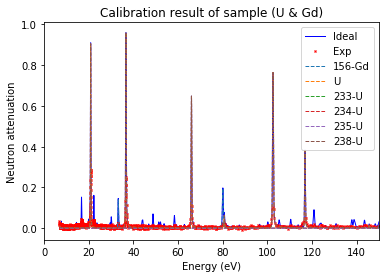

In [34]:
calibration.plot(table=False, grid=False, items_to_plot=['U', 'U*', 'Gd-156'])

## Fit resonances
### Class initialization

  - Pass all the parameters definded and calibrated into the FitResonance()

In [35]:
fit = FitResonance(spectra_file=spectra_file,
                   data_file=data_file,
                   folder=folder,
                   energy_min=energy_min,
                   energy_max=energy_max,
                   energy_step=energy_step,
                   calibrated_offset_us=calibration.calibrated_offset_us,
                   calibrated_source_to_detector_m=calibration.calibrated_source_to_detector_m,
                   baseline=True)

### Fitting equations
#### Beer-Lambert Law:

$$T\left( E \right) =\frac { I\left( E \right)  }{ { I }_{ 0 }\left( E \right)  } =exp\left[ -\sum\nolimits_i { { N }_{ i }{ d }_{ i } } \sum\nolimits_j { { \sigma  }_{ ij }\left( E \right) { A }_{ ij } }  \right]$$

${ N }_{ i }$ : number of atoms per unit volume of element $i$,

${ d }_{ i }$ : effective thickness along the neutron path of element $i$,

${ \sigma  }_{ ij }\left( E \right)$  : energy-dependent neutron total cross-section for the isotope $j$ of element $i$,

${ A }_{ ij }$ : abundance for the isotope $j$ of element $i$.

$${N_i} = {N_A}{C_i} = \frac { {N_A}{\rho_i}} {\sum\nolimits_j {m_{ij}{A_{ij}}}}$$

${N_A}$ : Avogadro’s number,

${C_i}$ : molar concentration of element $i$,

${\rho_i}$ : density of the element $i$,

$m_{ij}$ : atomic mass values for the isotope $j$ of element $i$.


#### How to fit the resonance signals

  - using **thickness** (mm) or **density** (g/cm<sup>3</sup>) to minimize the difference between the measured resonance signals and the simulated resonance signals from *ImagingReso* within the range specified in **global parameters**
  - **vary** can be one of **['thickness', 'density']** (default is **'density'**)
  - fitting parameters are displayed

In [36]:
fit_result = fit.fit(layer, vary='density')

-------Fitting (density)-------
Params before:
Name                Value      Min      Max   Stderr     Vary     Expr Brute_Step
density_gcm3_Gd     7.901        0      inf     None     True     None     None
density_gcm3_U      18.95        0      inf     None     True     None     None
thickness_mm_Gd      0.05        0      inf     None    False     None     None
thickness_mm_U       0.05        0      inf     None    False     None     None
Params after:
Name                Value      Min      Max   Stderr     Vary     Expr Brute_Step
density_gcm3_Gd     3.217        0      inf  0.04812     True     None     None
density_gcm3_U      2.589        0      inf  0.01818     True     None     None
thickness_mm_Gd      0.05        0      inf        0    False     None     None
thickness_mm_U       0.05        0      inf        0    False     None     None
Fitting chi^2 : 2.7164917570446554



### Output fitted result in molar concentration

  - unit: mol/cm<sup>3</sup>

In [37]:
fit.molar_conc()

Molar-conc. (mol/cm3)	Before_fit	After_fit
U	0.07961217820137899	0.010874916048358519
Gd	0.05024483306836248	0.020460587861440557




{'Gd': {'density': {'units': 'g/cm3', 'value': 3.2174274412115276},
  'layer': 'Gd',
  'molar_conc': {'units': 'mol/cm3', 'value': 0.020460587861440557},
  'molar_mass': {'units': 'g/mol', 'value': 157.25},
  'thickness': {'units': 'mm', 'value': 0.05}},
 'U': {'density': {'units': 'g/cm3', 'value': 2.5885444133322855},
  'layer': 'U',
  'molar_conc': {'units': 'mol/cm3', 'value': 0.010874916048358519},
  'molar_mass': {'units': 'g/mol', 'value': 238.02891},
  'thickness': {'units': 'mm', 'value': 0.05}}}

### Plot fitting result

  - using the best fitted **density** to show the measured resonance signals and the fitted resonance signals from *ImagingReso*
  - measured data before and after is ploted with raw data points instead of interpolated data points. However, the interpolated data was used during the fitting step above.

#### Default layout

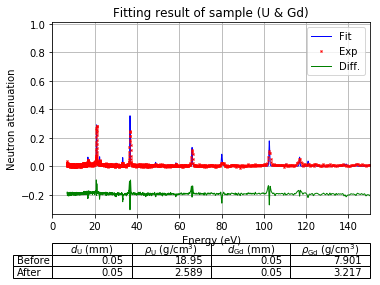

In [38]:
fit.plot()

#### Hide difference plot

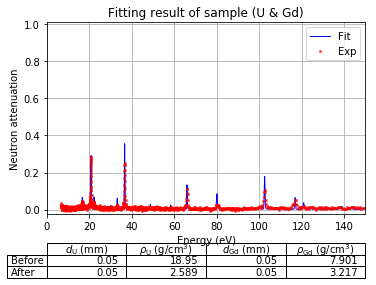

In [39]:
fit.plot(error=False)

#### Hide table

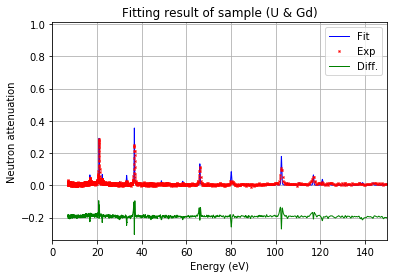

In [40]:
fit.plot(table=False)

#### Hide grid & show before

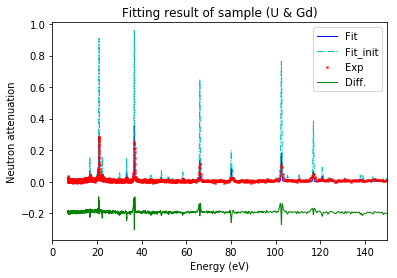

In [41]:
fit.plot(table=False, grid=False, before=True)

#### Show all elements

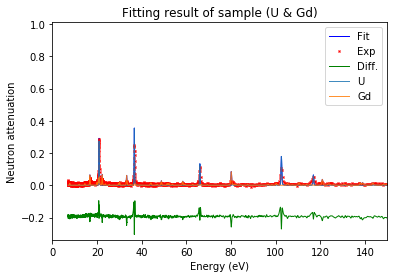

In [42]:
fit.plot(table=False, grid=False, all_elements=True)

#### Show all isotopes

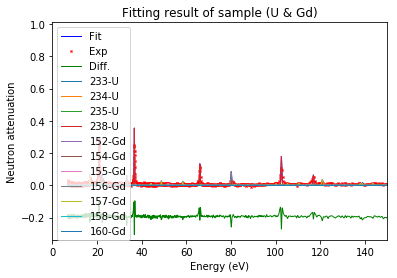

In [43]:
fit.plot(table=False, grid=False, all_isotopes=True)

#### Show specified items

- Format as **list** with each name in **string**

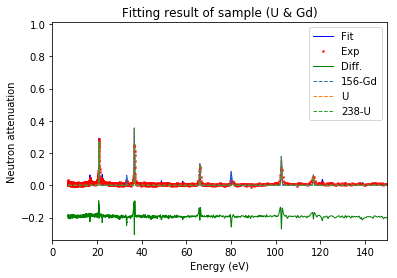

In [44]:
fit.plot(table=False, grid=False, items_to_plot=['U', 'U-238', 'Gd-156'])

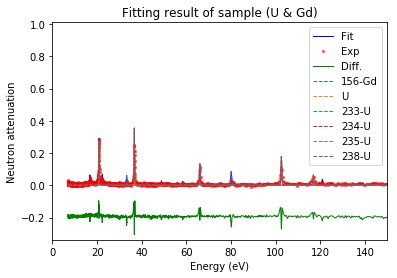

In [45]:
fit.plot(table=False, grid=False, items_to_plot=['U', 'U*', 'Gd-156'])

## Fit isotopic ratios

- specify the element you would like to perform isotopic (by at.%) fitting.

**Note**: Processing time of this step might be long.

In [46]:
fit.fit_iso(layer='U')

-------Fitting (isotopic at.%)-------
Params before:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
U233         0        0        1     None     True     None     None
U234   5.5e-05        0        1     None     True     None     None
U235    0.0072        0        1     None     True     None     None
U238    0.9927        0        1     None    False 1-U233-U234-U235     None
Params after:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
U233    0.0101        0        1  0.03743     True     None     None
U234  5.316e-06        0        1  0.04623     True     None     None
U235   0.06146        0        1  0.03617     True     None     None
U238    0.9284        0        1  0.05946    False 1-U233-U234-U235     None
Fit iso chi^2 : 2.700599444474776



In [47]:
fit.molar_conc()

Molar-conc. (mol/cm3)	Before_fit	After_fit
U	0.07968367366422123	0.01088468223204817
Gd	0.05024483306836248	0.020460587861440557




{'Gd': {'density': {'units': 'g/cm3', 'value': 3.2174274412115276},
  'layer': 'Gd',
  'molar_conc': {'units': 'mol/cm3', 'value': 0.020460587861440557},
  'molar_mass': {'units': 'g/mol', 'value': 157.25},
  'thickness': {'units': 'mm', 'value': 0.05}},
 'U': {'density': {'units': 'g/cm3', 'value': 2.5885444133322855},
  'layer': 'U',
  'molar_conc': {'units': 'mol/cm3', 'value': 0.01088468223204817},
  'molar_mass': {'units': 'g/mol', 'value': 237.81534069141117},
  'thickness': {'units': 'mm', 'value': 0.05}}}

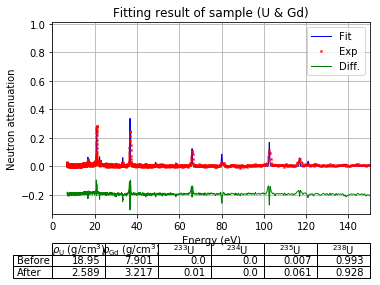

In [48]:
fit.plot()